In [1]:
import numpy as np
import pandas as pd
import astropy.io.fits as fits
import os
import sys
import glob

%matplotlib inline
import matplotlib.pyplot as plt

Read the fits event file

In [8]:
hdul = fits.open("scorefile_unpolarized.fits")
hdul.info()

events = hdul[1].data
print(events.columns)

t_ID = events['EventID']
t_ED = events['En_dep']
t_SI = events['Scint_ID']
t_XP = events['X_Primary']
t_YP = events['Y_Primary']
t_ZP = events['Z_Primary']
t_TP = events['Theta_Primary']
t_PP = events['Phi_Primary']
t_EP = events['En_Primary']
t_Dx = events['X_Detected']
t_Dy = events['Y_Detected']
t_Dz = events['Z_Detected']

Filename: scorefile_unpolarized.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  EVENTS        1 BinTableHDU     43   397935R x 12C   [1K, 1D, 1K, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D]   
ColDefs(
    name = 'EventID'; format = '1K'
    name = 'En_dep'; format = '1D'; unit = 'keV'
    name = 'Scint_ID'; format = '1K'
    name = 'X_Primary'; format = '1D'; unit = 'cm'
    name = 'Y_Primary'; format = '1D'; unit = 'cm'
    name = 'Z_Primary'; format = '1D'; unit = 'cm'
    name = 'Theta_Primary'; format = '1D'; unit = 'degree'
    name = 'Phi_Primary'; format = '1D'; unit = 'degree'
    name = 'En_Primary'; format = '1D'; unit = 'keV'
    name = 'X_Detected'; format = '1D'; unit = 'cm'
    name = 'Y_Detected'; format = '1D'; unit = 'cm'
    name = 'Z_Detected'; format = '1D'; unit = 'cm'
)


Create a pandas data frame

In [9]:
data = {'EventID': t_ID, 'En_dep': t_ED, 'Scint_ID': t_SI, 'X_Primary': t_XP, 'Y_Primary': t_YP, 'Z_Primary': t_ZP,
        'Theta_Primary': t_TP, 'Phi_Primary': t_PP, 'En_Primary': t_EP, 'X_Detected': t_Dx,
       'Y_Detected': t_Dy, 'Z_Detected': t_Dz}
df = pd.DataFrame(data)

Create the lookup table (Scint_ID, X_detected, Y_detected, Z_detected) for the scatterers detectors 

In [10]:
Scint_ID = []
X_Detected = []
Y_Detected = []
Z_Detected = []
for i in range(64):
    Scint_ID.append(int(df[df['Scint_ID'] == i+1].iloc[0,:]['Scint_ID']))
    X_Detected.append(df[df['Scint_ID'] == i+1].iloc[0,:]['X_Detected'])
    Y_Detected.append(df[df['Scint_ID'] == i+1].iloc[0,:]['Y_Detected'])
    Z_Detected.append(df[df['Scint_ID'] == i+1].iloc[0,:]['Z_Detected'])

# create the data frame
data = {'Scint_ID': Scint_ID, 'X_Detected': X_Detected, 'Y_Detected': Y_Detected,
       'Z_Detected': Z_Detected}
look_up_table_scatterer = pd.DataFrame(data)

Create the lookup table (Scint_ID, X_detected, Y_detected, Z_detected) for the absorbers detectors

In [11]:
Scint_ID = []
X_Detected = []
Y_Detected = []
Z_Detected = []
for i in range(32):
    Scint_ID.append(int(df[df['Scint_ID'] == i+101].iloc[0,:]['Scint_ID']))
    X_Detected.append(df[df['Scint_ID'] == i+101].iloc[0,:]['X_Detected'])
    Y_Detected.append(df[df['Scint_ID'] == i+101].iloc[0,:]['Y_Detected'])
    Z_Detected.append(df[df['Scint_ID'] == i+101].iloc[0,:]['Z_Detected'])

# create the data frame
data = {'Scint_ID': Scint_ID, 'X_Detected': X_Detected, 'Y_Detected': Y_Detected,
       'Z_Detected': Z_Detected}
look_up_table_absorber = pd.DataFrame(data)

Plot the (x,y) positions

position of the upper right detector: (-1.8641520384699106,21.666007041931152)


Text(0, 0.5, 'y (mm)')

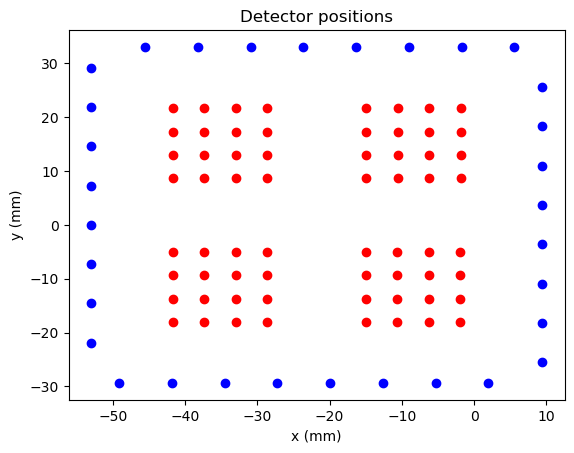

In [12]:
position_x = []
position_y = []
position_z = []
for i in range(len(look_up_table_scatterer)):
    position_x.append(look_up_table_scatterer.iloc[i,1])
    position_y.append(look_up_table_scatterer.iloc[i,2])
    position_z.append(look_up_table_scatterer.iloc[i,3])
plt.plot(position_x, position_y, 'o', color='red');
# print the position of the upper right scatterer
x_upper_right = np.max(position_x)
y_upper_right = np.max(position_y)
print('position of the upper right detector: ({},{})'.format(x_upper_right, y_upper_right))

position_x = []
position_y = []
position_z = []
for i in range(len(look_up_table_absorber)):
    position_x.append(look_up_table_absorber.iloc[i,1])
    position_y.append(look_up_table_absorber.iloc[i,2])
    position_z.append(look_up_table_scatterer.iloc[i,3])
plt.plot(position_x, position_y, 'o', color='blue');
    
plt.title('Detector positions')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')    

### Plot the z positions

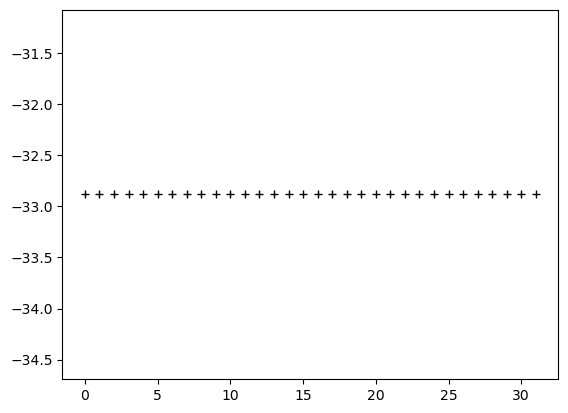

In [7]:
plt.plot(position_z, '+', color='black');

Plot the spectrum

In [8]:
# Group by ''EventID' column 
grouped = df.groupby('EventID')

# Perform aggregation
sum_by_category = grouped['En_dep'].sum()

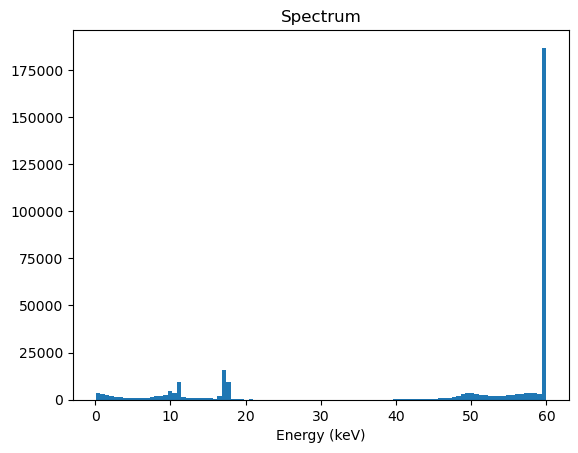

In [9]:
plt.hist(sum_by_category, bins=100);
plt.title('Spectrum');
plt.xlabel('Energy (keV)');

### The effective area

Parameters

In [29]:
energy = 60 # keV
no_photons = 1e+6
area_beam = 8 * 8 # cm^2

We evaluate below the number of detecte photons (no_detected_photons).
We must define first the readout and the logic. As a very first approssimation a photo is detected if there is at leat one energy deposit in a detector (absorber or scatterer).

In [30]:
# Group by ''EventID' column 
grouped = df.groupby('EventID')

# Perform aggregation
sum_by_category = grouped['En_dep'].sum()

no_detected_photons = len(sum_by_category)

effective area (area_eff)

In [31]:
area_eff = area_geom * ( no_detected_photons / no_photons)
print('effective area = {} cm^2'.format(area_eff))

effective area = 20.980224 cm^2
